# Simultaneous Quantiles

---

---

### Overview

This notebook trains two variations of models which can be used to estimate aleatoric uncertainty.  The first does not include any additional monotonic features, and the second does.

A special loss function is used that allows us to predict any quantile with a single training step, and to change that quantile arbitrarily, without requiring retraining.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.SimultaneousQuantiles import SimultaneousQuantilesRegressor, SimultaneousQuantilesNet, SimultaneousQuantilesMixedMonotonicNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [49]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Train a model without monotonicity constraints

Similar to `MixedMonotonicNet()`, `SimultaneousQuantilesNet()` takes another network as an input argument whose `.forward()` pass has exactly one input named `X_non_monotonic` (`SimultaneousQuantilesRegressor()` adds an extra feature which is monotonically constrained to estimate the quantile).

In [50]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(3 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1:].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

`module__` parameters are similar to the [mixed_monotonic](./mixed_monotonic.ipynb) example, with the exception of not needing `dim_monotonic` as input.

In [51]:
model = SimultaneousQuantilesRegressor(SimultaneousQuantilesNet,
                                       max_epochs=20,
                                       lr=0.001,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__non_monotonic_net=EmbeddingNet(),
                                       module__dim_non_monotonic=16,
                                       module__layers=[128, 128, 32],
                                       module__integration_steps=300)

Now we can pass in a `dict` with only one key `X_non_monotonic` to our model's `.fit()` method.  Note, that `x1` and `x2` are listed after `x3` to align with how `EmbeddingNet()` parses `X_non_monotonic`.

In [52]:
model.fit({'X_non_monotonic': df[['x3', 'x4', 'x1', 'x2']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2014        0.1591  4.8856
      2        0.1733        0.1782  4.9179
      3        0.1734        0.1701  4.8159
      4        0.1587        0.1714  4.8095
      5        0.1618        0.1664  4.9100
      6        0.1568        0.1648  5.0610
      7        0.1593        0.1541  5.3725
      8        0.1521        0.1598  5.1398
      9        0.1469        0.1510  4.7720
     10        0.1442        0.1581  4.5164
     11        0.1452        0.1663  4.5674
     12        0.1415        0.1628  4.4660
     13        0.1479        0.1522  4.5404
     14        0.1377        0.1727  4.6901
     15        0.1374        0.1681  4.5169
     16        0.1384        0.1591  4.5115
     17        0.1358        0.1717  4.5444
     18        0.1376        0.1701  4.6132
     19        0.1315        0.1633  4.5465
     20        0.1284        0.1593  4.4759


<class 'tabularasa.SimultaneousQuantiles.SimultaneousQuantilesRegressor'>[initialized](
  module_=SimultaneousQuantilesNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=19, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
   

---

### Aleatoric uncertainty

Let's grab a single .

In [53]:
holdout = pd.read_pickle('./data/simple_test.pkl')

In [54]:
holdout = holdout.drop_duplicates(subset='x1').sort_values('x1')

In [55]:
holdout = df[df['x3'] == 0].copy()

`SimulatedQuantilesRegressor().predict()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [56]:
p05 = model.predict({'X_non_monotonic': holdout[['x3', 'x4', 'x1', 'x2']].values}, q=0.05)
p25 = model.predict({'X_non_monotonic': holdout[['x3', 'x4', 'x1', 'x2']].values}, q=0.25)
p50 = model.predict({'X_non_monotonic': holdout[['x3', 'x4', 'x1', 'x2']].values}, q=0.5)
p75 = model.predict({'X_non_monotonic': holdout[['x3', 'x4', 'x1', 'x2']].values}, q=0.75)
p95 = model.predict({'X_non_monotonic': holdout[['x3', 'x4', 'x1', 'x2']].values}, q=0.95)

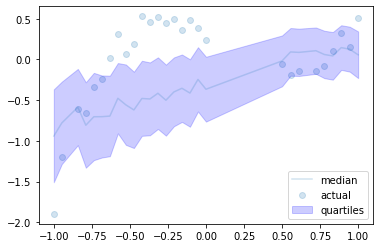

In [57]:
plt.scatter(holdout['x1'], holdout['y'], alpha=0.2, label='actual')
plt.plot(holdout['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(holdout['x1'], p25.flatten(), p75.flatten(), color='blue', alpha=0.2, label='quartiles')
#plt.fill_between(holdout['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')

plt.legend()
plt.show()

This does not look good at all...  Maybe I was just overfitting.

Wider interval here, but much worse fit... I wonder if something is happening with my random number generation?

In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [5]:
model = SimultaneousQuantileRegressor(SimultaneousQuantileMixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [6]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5811        0.4595  10.3075
      2        0.3487        0.2315  9.4292
      3        0.2238        0.2295  9.2418
      4        0.2224        0.1868  9.2474
      5        0.2035        0.2347  9.2152
      6        0.2024        0.1963  8.7851
      7        0.2000        0.2031  8.8613
      8        0.2014        0.1922  8.8707
      9        0.1924        0.2000  9.0655
     10        0.1878        0.1973  8.9809
     11        0.1982        0.1897  8.9462
     12        0.1923        0.2135  8.8839
     13        0.1925        0.1929  8.7842


<class 'tabularasa.SimultaneousQuantileRegressor.SimultaneousQuantileRegressor'>[initialized](
  module_=SimultaneousQuantileMixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
       

In [7]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [8]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

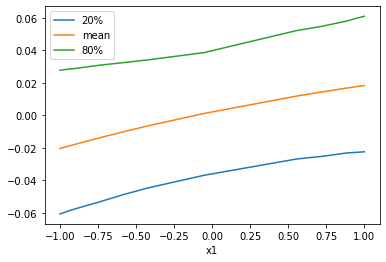

In [9]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

In [10]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values})

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [11]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5)

array([[-0.00588573],
       [ 0.04773763],
       [ 0.06194977],
       ...,
       [ 0.0665164 ],
       [ 0.07168144],
       [ 0.06724489]], dtype=float32)

In [12]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.9)

array([[2.5714515e-05],
       [4.9877182e-02],
       [6.4310715e-02],
       ...,
       [6.8276986e-02],
       [7.3422000e-02],
       [6.8904407e-02]], dtype=float32)

In [13]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.1)

array([[-0.0120576 ],
       [ 0.04543061],
       [ 0.05940571],
       ...,
       [ 0.06460671],
       [ 0.06979516],
       [ 0.06544493]], dtype=float32)

In [14]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5, last_hidden_layer=True)

array([[1.8008924, 1.       , 1.8807808, ..., 2.6754327, 1.8818873,
        1.       ],
       [2.2934756, 1.       , 2.3940916, ..., 3.5926368, 2.3543181,
        1.       ],
       [2.2879782, 1.       , 2.372876 , ..., 3.5557475, 2.3435197,
        1.       ],
       ...,
       [2.653592 , 1.       , 2.5795307, ..., 4.14019  , 2.5826511,
        1.       ],
       [2.661717 , 1.       , 2.590844 , ..., 4.161422 , 2.5904365,
        1.       ],
       [2.6822915, 1.       , 2.604792 , ..., 4.198989 , 2.6081073,
        1.       ]], dtype=float32)